### 📊 Daily Sales Forecasting with ARIMA Model 🔮

### Business Problem Statement

A retail company records daily sales data for its stores. Management wants to:

Understand sales patterns over time (trends, seasonality, short-term fluctuations).

Forecast future sales to improve inventory planning, staff scheduling, and cash flow management.

Evaluate forecast accuracy to decide if ARIMA is reliable for their planning, or if they should explore more advanced models.

Key Question:
"Given historical daily sales, can we build a time series model that forecasts the next 14 days of sales with reasonable accuracy?"

# Time Series Forecasting on Daily Sales 


### 1) Load & clean data (dates, gaps, duplicates)
### 2) Visualize series + 7-day rolling trend
### 3) Stationarity check (ADF) and automatic differencing (d)
### 4) ACF/PACF plots + human-readable observations
### 5) Train/Test split
### 6) ARIMA model selection (small grid search on p,q; d fixed)
### 7) Forecast, evaluate (RMSE & MAPE), and plot results
### 8) Future forecast (next 14 days)



In [4]:
# -----------------------------
# SECTION 1: Imports & Settings
# -----------------------------
import warnings
warnings.filterwarnings("ignore")  # keep the output tidy for class

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [17]:
# Make plots look decent for look
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

# ------------------------------------
# SECTION 2: Load the dataset (CSV)
# ------------------------------------
# NOTE: Update the path if your file is elsewhere.
CSV_PATH = "dailysales.csv"

# We read only the needed columns and parse dates explicitly for clarity.
# If your date format is different, adjust 'format' below or set infer_datetime_format=True.

df_raw = pd.read_csv(
    CSV_PATH,
    usecols=["date", "sales"]
)
# Parse date column; format '%d-%b-%y' matches '01-Jan-18'. If unsure, use pd.to_datetime with infer.
try:
    df_raw["date"] = pd.to_datetime(df_raw["date"], format="%d-%b-%y")
except Exception:
    df_raw["date"] = pd.to_datetime(df_raw["date"], infer_datetime_format=True)


df_raw.head()

,date,sales
0,2018-01-01,477.0
1,2018-01-02,365.0
2,2018-01-03,442.0
3,2018-01-04,490.0
4,2018-01-05,396.0


In [18]:
df_raw.tail()

,date,sales
699,2019-12-27,133.0
700,2019-12-28,214.1
701,2019-12-29,85.5
702,2019-12-30,182.9
703,2019-12-31,322.7


In [19]:
# -------------------------------------------
# SECTION 3: Basic Cleaning & Quality Checks
# -------------------------------------------
# Sort by date and drop exact duplicate rows (if any)
df_raw = df_raw.sort_values("date").drop_duplicates(subset=["date"], keep="last")

# keep='first' (default) → keeps the first occurrence of the duplicate row and drops the rest.

# keep='last' → keeps the last occurrence of the duplicate row and drops the earlier ones.

# keep=False → drops all occurrences of the duplicates (nothing is kept).



ts = df_raw.set_index("date")["sales"].astype("float64")

# Create a time series of sales with 'date' as index and values as float


In [20]:
ts

date
2018-01-01    477.0
2018-01-02    365.0
2018-01-03    442.0
2018-01-04    490.0
2018-01-05    396.0
              ...  
2019-12-27    133.0
2019-12-28    214.1
2019-12-29     85.5
2019-12-30    182.9
2019-12-31    322.7
Name: sales, Length: 703, dtype: float64

In [22]:
ts.index.max()

Timestamp('2019-12-31 00:00:00')

In [23]:
full_index = pd.date_range(ts.index.min(), ts.index.max(), freq="D")  
full_index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=730, freq='D')

In [24]:

# Ensure daily frequency (fills gaps if any)

full_index = pd.date_range(ts.index.min(), ts.index.max(), freq="D")  

# Create a complete daily date range from min to max date
ts = ts.reindex(full_index)  
# Reindex time series to include all dates (fill missing dates with NaN)
ts

2018-01-01    477.0
2018-01-02    365.0
2018-01-03    442.0
2018-01-04    490.0
2018-01-05    396.0
              ...  
2019-12-27    133.0
2019-12-28    214.1
2019-12-29     85.5
2019-12-30    182.9
2019-12-31    322.7
Freq: D, Name: sales, Length: 730, dtype: float64

In [25]:
missing_days = ts.isna().sum()
missing_days

27

In [26]:
# Report missing days and fill them (for teaching simplicity we use linear interpolation)

print(f"Data span: {ts.index.min().date()} to {ts.index.max().date()} ({len(ts)} days)")

print(f"Missing days found and interpolated: {missing_days}")

ts = ts.interpolate(method="time")

# Fill missing values in the time series using time-based linear interpolation


Data span: 2018-01-01 to 2019-12-31 (730 days)
Missing days found and interpolated: 27


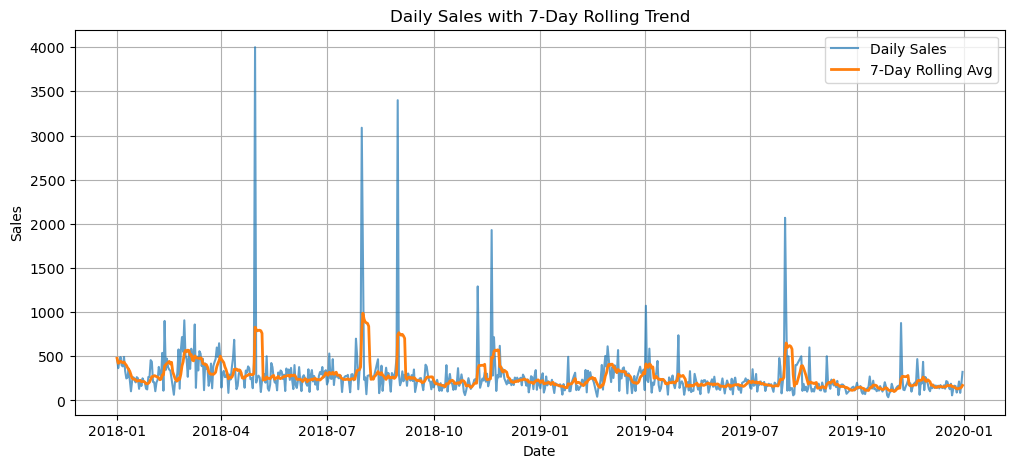

In [27]:

# --------------------------------------
# SECTION 4: Visualize Series & Trend
# --------------------------------------
plt.figure()
plt.plot(ts.index, ts.values, label="Daily Sales", alpha=0.7)

plt.plot(ts.index, ts.rolling(window=7, min_periods=1).mean().values,
         label="7-Day Rolling Avg", linewidth=2)
plt.title("Daily Sales with 7-Day Rolling Trend")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.show()


In [28]:

# --------------------------------------------------------
# SECTION 5: Stationarity Check (ADF) and Differencing (d)
# --------------------------------------------------------
def adf_summary(series, label="Series"):
    """Run ADF test and print a friendly summary."""
    result = adfuller(series.dropna(), autolag="AIC")
    
    adf_stat, pvalue = result[0], result[1]
    print(f"\nADF Test on {label}:")
    print(f"  ADF Statistic = {adf_stat:.3f}")
    print(f"  p-value       = {pvalue:.4f}")
    print("  Interpretation:",
          "Stationary ✅ (reject H0)" if pvalue <= 0.05 else "Non-stationary ❌ (fail to reject H0)")
    return pvalue

# Automatically choose minimal differencing d ∈ {0,1,2} to reach stationarity
d = 0
pval0 = adf_summary(ts, "Original series")
if pval0 > 0.05:
    d = 1
    pval1 = adf_summary(ts.diff(1), "1st difference")
    if pval1 > 0.05:
        d = 2
        pval2 = adf_summary(ts.diff(2), "2nd difference")

print(f"\nChosen differencing order d = {d}")

# This is the series we'll use for ACF/PACF inspection
ts_for_plots = ts if d == 0 else ts.diff(d)
ts_for_plots = ts_for_plots.dropna()




ADF Test on Original series:
  ADF Statistic = -21.634
  p-value       = 0.0000
  Interpretation: Stationary ✅ (reject H0)

Chosen differencing order d = 0


In [29]:
max_lags = min(40, len(ts_for_plots) // 3)  # safe bound for short series
max_lags

40

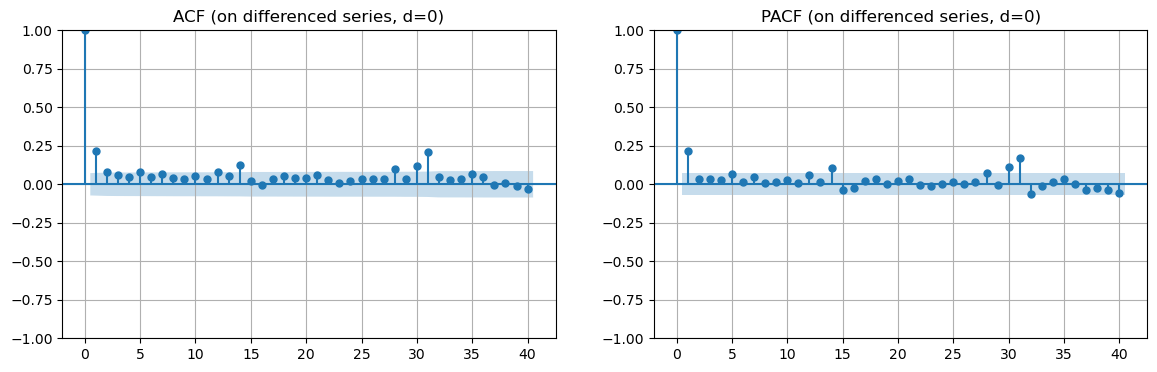


--- ACF/PACF Observations (talking points for class) ---
Significant ACF lags (first 40 checked): []
Significant PACF lags (first 40 checked): []
No strong weekly seasonal spikes detected in ACF.
PACF suggests AR component up to ~0 (cutoff behavior).
ACF suggests MA component up to ~0 (cutoff behavior).
We will still confirm p & q via a small AIC-based grid search.


In [30]:
# --------------------------------------------------------
# SECTION 6: ACF & PACF 
# --------------------------------------------------------
# Plot the ACF/PACF for visual teaching
max_lags = min(40, len(ts_for_plots) // 3)  # safe bound for short series

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_for_plots, lags=max_lags, ax=axes[0])
plot_pacf(ts_for_plots, lags=max_lags, ax=axes[1])
axes[0].set_title(f"ACF (on differenced series, d={d})")
axes[1].set_title(f"PACF (on differenced series, d={d})")
plt.show()

# Compute significant lags programmatically (95% CI) for observations text
acf_vals, acf_ci = acf(ts_for_plots, nlags=max_lags, alpha=0.05, fft=True)
pacf_vals, pacf_ci = pacf(ts_for_plots, nlags=max_lags, alpha=0.05, method="ywmle")

def significant_lags(values, ci):
    sig = []
    for lag in range(1, len(values)):
        lower, upper = ci[lag]
        if values[lag] < lower or values[lag] > upper:
            sig.append(lag)
    return sig

acf_sig = significant_lags(acf_vals, acf_ci)
pacf_sig = significant_lags(pacf_vals, pacf_ci)

# Detect simple weekly seasonality clue (daily data): spikes near lag 7,14,21...
seasonal_flags = [lag for lag in acf_sig if lag % 7 == 0]

print("\n--- ACF/PACF Observations (talking points for class) ---")
print(f"Significant ACF lags (first {max_lags} checked): {acf_sig[:10]}{' ...' if len(acf_sig)>10 else ''}")
print(f"Significant PACF lags (first {max_lags} checked): {pacf_sig[:10]}{' ...' if len(pacf_sig)>10 else ''}")

# Heuristic suggestions:
def consecutive_head(lags):
    """Return length of the longest initial consecutive run starting at 1."""
    run = 0
    for k in range(1, 10):  # up to 9 for readability
        if k in lags:
            run += 1
        else:
            break
    return run

p_guess = consecutive_head(pacf_sig)  # AR order from PACF cutoff
q_guess = consecutive_head(acf_sig)   # MA order from ACF cutoff

if 7 in acf_sig or 14 in acf_sig or 21 in acf_sig:
    print("ACF shows spikes at multiples of 7 → possible weekly seasonality (consider SARIMA).")
else:
    print("No strong weekly seasonal spikes detected in ACF.")

print(f"PACF suggests AR component up to ~{p_guess} (cutoff behavior).")
print(f"ACF suggests MA component up to ~{q_guess} (cutoff behavior).")
print("We will still confirm p & q via a small AIC-based grid search.")



In [31]:
# --------------------------------------------------------
# SECTION 7: Train/Test Split
# --------------------------------------------------------
# Use the last ~20% (capped between 14 and 30 points) as test for evaluation
N = len(ts)
test_size = max(14, min(30, N // 5))
print('\n',N)
print('\n',test_size)
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print(f"\nTrain size: {len(train)} points, Test size: {len(test)} points")



 730

 30

Train size: 700 points, Test size: 30 points


In [11]:

# --------------------------------------------------------
# SECTION 8: Model selection for (p,q) via small grid search
# --------------------------------------------------------
# We keep d fixed (from ADF). Try small values for p,q (0..3) to avoid overfitting.

pq_candidates = [(p, q) for p in range(0, 4) for q in range(0, 4)]

best_order = None
best_aic = np.inf
best_model = None

for p, q in pq_candidates:
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = (p, d, q)
            best_model = fitted
    except Exception:
        # Some (p,q) combos can fail to converge; just skip them
        continue

print(f"\nBest ARIMA order by AIC on train: {best_order} (AIC={best_aic:.2f})")




Best ARIMA order by AIC on train: (2, 0, 1) (AIC=9831.22)



Evaluation on Test Set:
  RMSE = 75.488
  MAPE = 54.63%


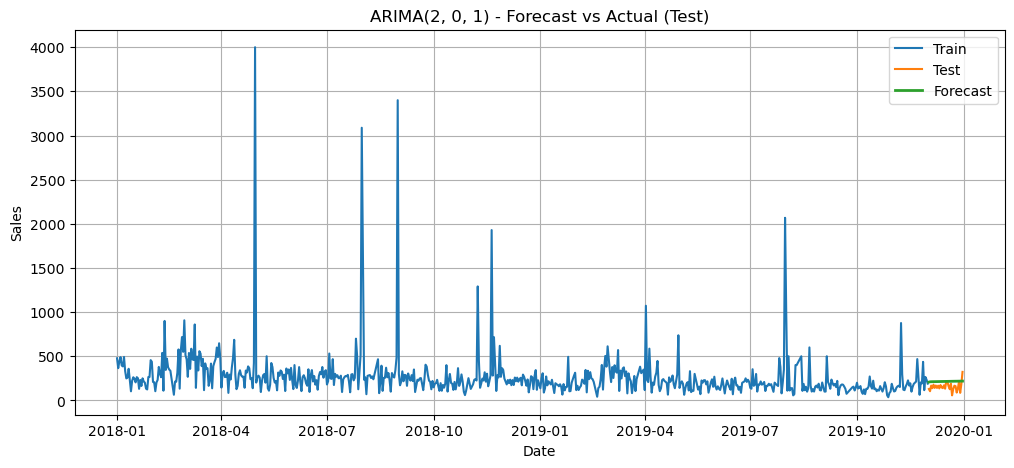

In [35]:
# --------------------------------------------------------
# SECTION 9: Forecast on the test set & evaluate
# --------------------------------------------------------
# Forecast exactly the test horizon
steps = len(test)
pred = best_model.forecast(steps=steps)
pred.index = test.index  # align for plotting

rmse = np.sqrt(mean_squared_error(test, pred))
mape = mean_absolute_percentage_error(test, pred) * 100

print("\nEvaluation on Test Set:")
print(f"  RMSE = {rmse:.3f}")
print(f"  MAPE = {mape:.2f}%")

# Plot Train/Test/Forecast for the audience
plt.figure()
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test")
plt.plot(pred.index, pred.values, label="Forecast", linewidth=2)
plt.title(f"ARIMA{best_order} - Forecast vs Actual (Test)")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.show()



Next 14 days forecast:
              forecast
2020-01-01  218.585907
2020-01-02  200.210998
2020-01-03  197.128188
2020-01-04  196.772246
2020-01-05  196.901987
2020-01-06  197.117666
2020-01-07  197.347987
2020-01-08  197.580235
2020-01-09  197.812145
2020-01-10  198.043314
2020-01-11  198.273673
2020-01-12  198.503214
2020-01-13  198.731935
2020-01-14  198.959841


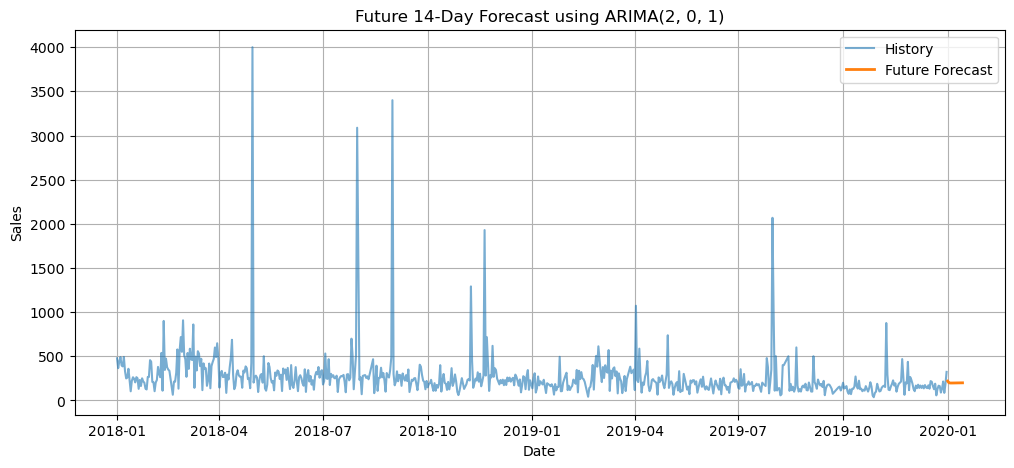

In [36]:

# --------------------------------------------------------
# SECTION 10: Future Forecast (next 14 days)
# --------------------------------------------------------
final_model = ARIMA(ts, order=best_order).fit()

future_steps = 14

future_fcst = final_model.forecast(steps=future_steps)


print(f"\nNext {future_steps} days forecast:")
print(future_fcst.to_frame(name='forecast'))

plt.figure()
plt.plot(ts.index, ts.values, label="History", alpha=0.6)
plt.plot(future_fcst.index, future_fcst.values, label="Future Forecast", linewidth=2)
plt.title(f"Future {future_steps}-Day Forecast using ARIMA{best_order}")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend()
plt.show()


In [14]:

# --------------------------------------------------------
# SECTION 11: Summary
# --------------------------------------------------------

print("- We chose 'd' (differencing) by testing stationarity with ADF and picking the smallest d that makes the series stationary.")
print("- AIC balances fit vs complexity: lower AIC is better because it rewards fit but penalizes too many parameters.")
print(f"- ACF shows correlation at lags: {acf_sig[:10]}{' ...' if len(acf_sig)>10 else ''}.")
print(f"- PACF shows partial correlation at lags: {pacf_sig[:10]}{' ...' if len(pacf_sig)>10 else ''}.")
print("- Heuristic: PACF cutoff → AR order (p), ACF cutoff → MA order (q).")
print(f"- We validated (p,q) with a quick grid search and selected ARIMA{best_order} by minimum AIC.")


- We chose 'd' (differencing) by testing stationarity with ADF and picking the smallest d that makes the series stationary.
- AIC balances fit vs complexity: lower AIC is better because it rewards fit but penalizes too many parameters.
- ACF shows correlation at lags: [].
- PACF shows partial correlation at lags: [].
- Heuristic: PACF cutoff → AR order (p), ACF cutoff → MA order (q).
- We validated (p,q) with a quick grid search and selected ARIMA(2, 0, 1) by minimum AIC.


In [15]:
### perplexity solution


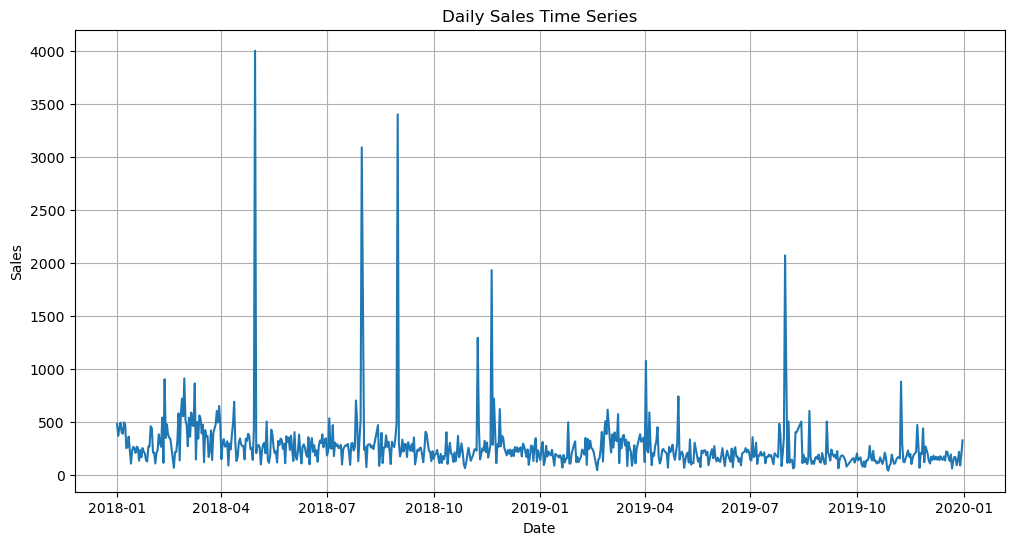

ADF Statistic: -22.95917537558697
p-value: 0.0
ADF Statistic after 1st difference: -12.866992131566057
p-value after 1st difference: 4.970910289260137e-24


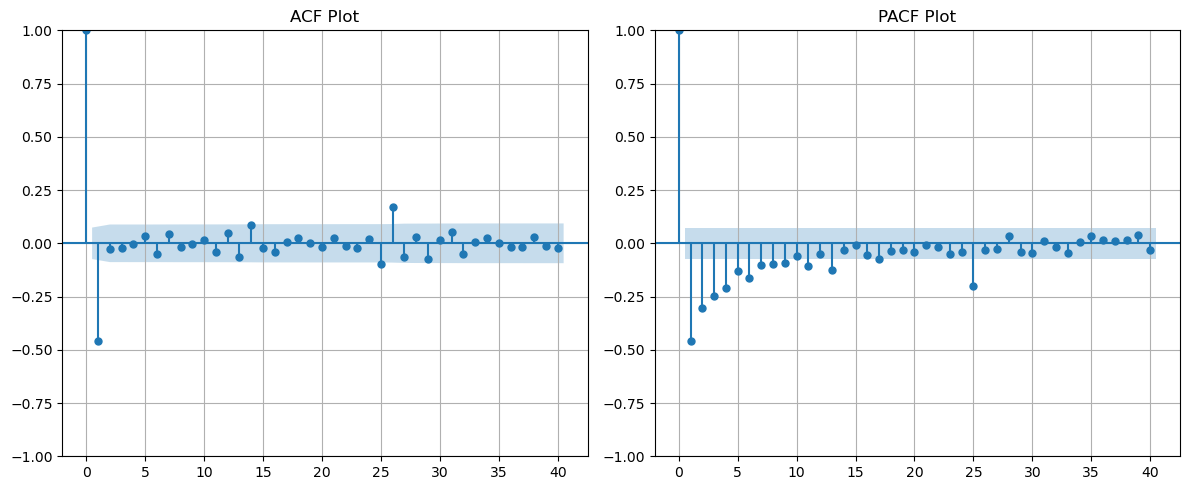

RMSE: 128.13
MAPE: 84.95%


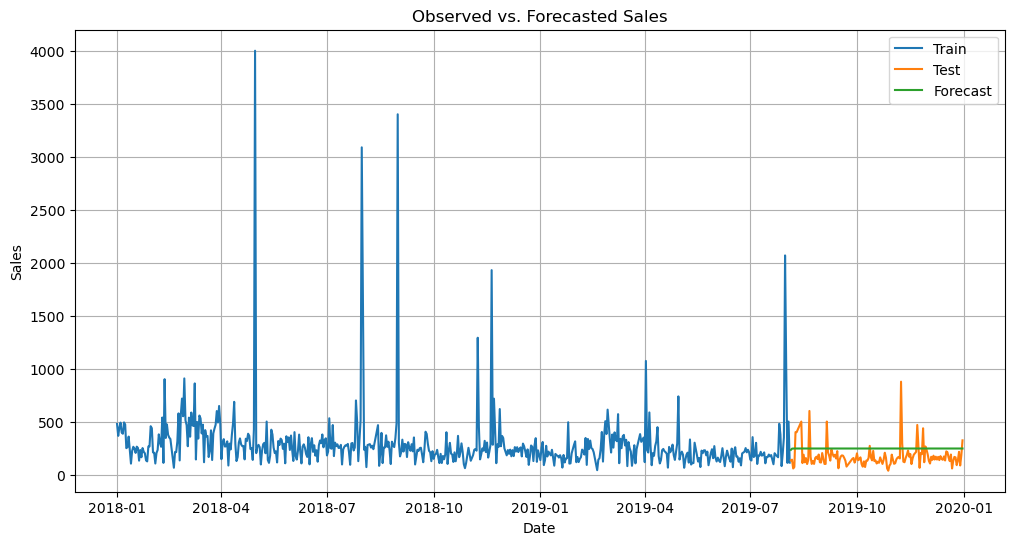

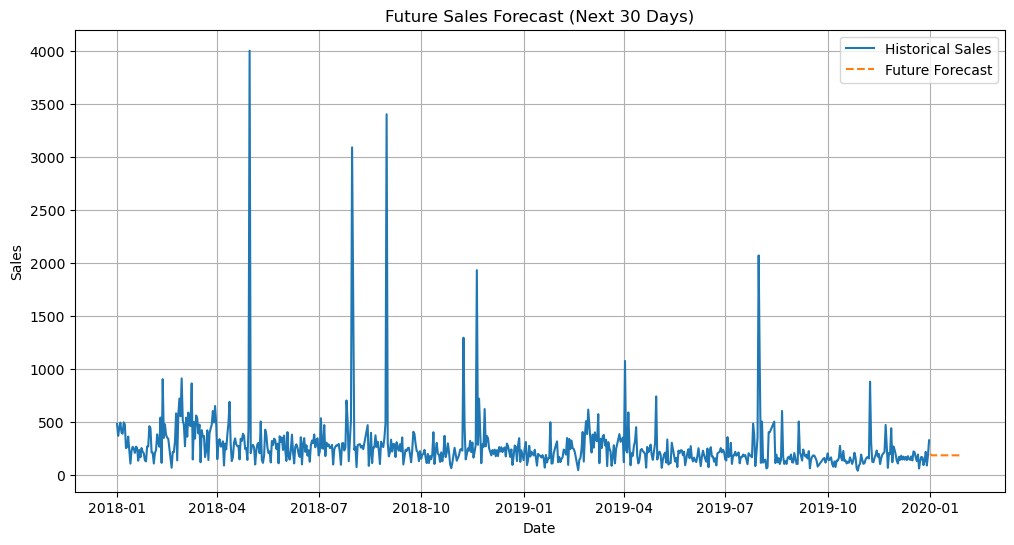

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Step 1: Load the data
# Note: Make sure 'dailysales.csv' is in your working directory
data = pd.read_csv('dailysales.csv')

# Parse dates and sort
data['date'] = pd.to_datetime(data['date'], format='%d-%b-%y')
data = data.sort_values('date')
data = data.set_index('date')

# Aggregate sales if any duplicate dates
data = data.groupby('date').sum()

# Step 2: Visualize time series
plt.figure(figsize=(12,6))
plt.plot(data.index, data['sales'])
plt.title('Daily Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Step 3: Augmented Dickey-Fuller test for stationarity
result = adfuller(data['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print('Series is non-stationary, will use d=1.')

# Step 4: Differencing (d=1)
data_diff = data['sales'].diff().dropna()

# Optional: ADF test on differenced series
result_diff = adfuller(data_diff)
print('ADF Statistic after 1st difference:', result_diff[0])
print('p-value after 1st difference:', result_diff[1])

# Step 5: Plot ACF and PACF to select p, q
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.title('ACF Plot')

plt.subplot(1,2,2)
plot_pacf(data_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

# Based on plots: choose p and q. 
# (This can be interpreted manually, for example p=1 (PACF first lag significant), q=1 (ACF first lag significant))
# For demonstration, let's use p=1 and q=1.
p, d, q = 1, 1, 1

# Step 6: Train/test split (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Step 7: Fit ARIMA model
model = ARIMA(train['sales'], order=(p, d, q))
model_fit = model.fit()

# Step 8: Forecast on test set
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

# Step 9: Evaluate performance with RMSE & MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], forecast))
mape = mean_absolute_percentage_error(test['sales'], forecast) * 100
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Step 10: Plot observed vs predicted
plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Test')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title('Observed vs. Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 11: Future forecast (next 30 days)
future_steps = 30
model_full = ARIMA(data['sales'], order=(p, d, q))
model_full_fit = model_full.fit()
future_forecast = model_full_fit.forecast(steps=future_steps)
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Step 12: Plot future forecast
plt.figure(figsize=(12,6))
plt.plot(data.index, data['sales'], label='Historical Sales')
plt.plot(future_dates, future_forecast, label='Future Forecast', linestyle='--')
plt.title('Future Sales Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
